# Proyek Klasifikasi Gambar: Oily, Dry and Normal Skin Types w DenseNet121

## Import Library

In [ ]:
# !pip install split-folders

In [2]:
import os, shutil
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files,drive
import gdown
import zipfile

In [3]:
import cv2
import keras
from PIL import Image
# from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, MaxPool2D
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score, confusion_matrix,classification_report
from collections import Counter

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

### Data Loading

In [8]:
!cp -r /content/drive/MyDrive/capstone-project/skin_dataset.zip ./skin_dataset.zip

In [9]:
!unzip -q /content/skin_dataset.zip -d ./

In [10]:
train_dataset_dir='/content/skin_dataset/train'
test_dataset_dir='/content/skin_dataset/test'
val_dataset_dir='/content/skin_dataset/valid'

base_dataset_dir='/content/skin_dataset'

In [11]:
splits = ['train', 'test', 'valid']
selected_categories = ['kering', 'normal', 'berminyak']
def create_join_folder(base_split_dir, categories):
    joined_dir = os.path.join(base_split_dir, 'joined')
    os.makedirs(joined_dir, exist_ok=True)

    for category in categories:
        category_dir = os.path.join(base_split_dir, category)
        if os.path.isdir(category_dir):
            for filename in os.listdir(category_dir):
                src_file = os.path.join(category_dir, filename)
                if os.path.isfile(src_file):

                    dst_file = os.path.join(joined_dir, f"{filename}")
                    shutil.copy2(src_file, dst_file)

for split in splits:
    split_dir = os.path.join(base_dataset_dir, split)
    create_join_folder(split_dir, selected_categories)

### Checking Image Resolution

In [12]:
data = []

for split in splits:
    joined_dir = os.path.join(base_dataset_dir, split, 'joined')
    if os.path.isdir(joined_dir):
        for filename in os.listdir(joined_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(joined_dir, filename)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        data.append({
                            'filename': filename,
                            'split': split,
                            'width': width,
                            'height': height
                        })
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

image_resolution_df = pd.DataFrame(data)
image_resolution_df.head()


,filename,split,width,height
0,minyak-38-_jpg.rf.a5b201a466430196082b9ed413e4...,train,300,300
1,normal-87-_jpg.rf.ebd2e349e37ba97499bd742381ff...,train,300,300
2,kering-112-_jpg.rf.be6d78093beb3ab0c466712df70...,train,300,300
3,kering-103-_jpg.rf.cf49537fe58dfebd58bd90b0c1c...,train,300,300
4,normal-84-_jpg.rf.ff97d2ba3a74b592ca3f1a10ac42...,train,300,300


In [13]:
print("\nResolusi yang ditemukan:")
print(image_resolution_df[['width', 'height']].value_counts().reset_index(name='count'))


Resolusi yang ditemukan:
   width  height  count
0    300     300   3944


### Data Preprocessing

#### Plot Distribusi

In [14]:
def extract_label_from_filename(fname):
    fname_lower = fname.lower()
    if 'kering' in fname_lower:
        return 'kering'
    elif 'normal' in fname_lower:
        return 'normal'
    elif 'berminyak' in fname_lower or 'minyak' in fname_lower:
        return 'berminyak'
    else:
        return 'unknown'

<ipython-input-15-5cdbc891fb37>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=subset_df, x='labels', palette='Set3')
<ipython-input-15-5cdbc891fb37>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=subset_df, x='labels', palette='Set3')
<ipython-input-15-5cdbc891fb37>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=subset_df, x='labels', palette='Set3')


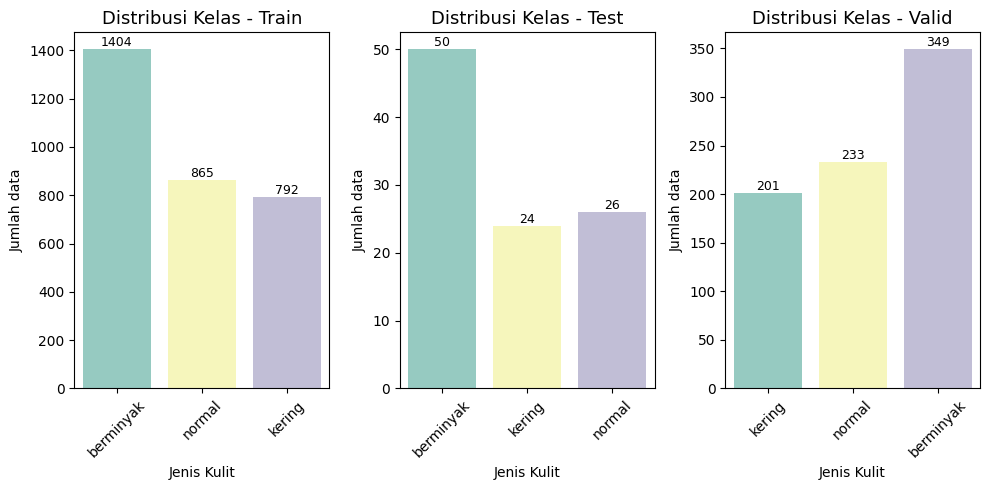

In [15]:
file_name = []
labels = []
full_path = []
split_names = []

for split in splits:
    joined_path = os.path.join(base_dataset_dir, split, 'joined')
    if os.path.isdir(joined_path):
        for fname in os.listdir(joined_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path.append(os.path.join(joined_path, fname))
                file_name.append(fname)
                split_names.append(split)

                label = extract_label_from_filename(fname)
                labels.append(label)


skin_image_df = pd.DataFrame({
    'path': full_path,
    'file_name': file_name,
    'labels': labels,
    'split': split_names
})
splits = skin_image_df['split'].unique()

plt.figure(figsize=(10, 5))

for i, split in enumerate(splits):
    plt.subplot(1, len(splits), i+1)
    subset_df = skin_image_df[skin_image_df['split'] == split]

    ax = sns.countplot(data=subset_df, x='labels', palette='Set3')

    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fontsize=9)

    plt.title(f"Distribusi Kelas - {split.capitalize()}", fontsize=13)
    plt.xlabel("Jenis Kulit")
    plt.ylabel("Jumlah data")
    plt.xticks(rotation=45)

plt.tight_layout()

In [16]:
skin_image_df.head()

,path,file_name,labels,split
0,/content/skin_dataset/train/joined/minyak-38-_...,minyak-38-_jpg.rf.a5b201a466430196082b9ed413e4...,berminyak,train
1,/content/skin_dataset/train/joined/normal-87-_...,normal-87-_jpg.rf.ebd2e349e37ba97499bd742381ff...,normal,train
2,/content/skin_dataset/train/joined/kering-112-...,kering-112-_jpg.rf.be6d78093beb3ab0c466712df70...,kering,train
3,/content/skin_dataset/train/joined/kering-103-...,kering-103-_jpg.rf.cf49537fe58dfebd58bd90b0c1c...,kering,train
4,/content/skin_dataset/train/joined/normal-84-_...,normal-84-_jpg.rf.ff97d2ba3a74b592ca3f1a10ac42...,normal,train


In [17]:
print(skin_image_df['labels'].unique())

['berminyak' 'normal' 'kering']


#### Undersampling

**Train Data**

In [18]:
undersampled_train_dir = '/content/skin_dataset/train_undersampled'
joined_train_dataset_dir='/content/skin_dataset/train/joined'


os.makedirs(undersampled_train_dir, exist_ok=True)
file_names = [f for f in os.listdir(joined_train_dataset_dir) if os.path.isfile(os.path.join(joined_train_dataset_dir, f))]
labels = [extract_label_from_filename(f) for f in file_names]

# Hitung distribusi
label_counts = Counter(labels)
print("Distribusi kelas Train:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")

train_file_df = pd.DataFrame({
    'filename': file_names,
    'label': labels
})
train_file_df['filepath'] =train_file_df['filename'].apply(lambda x: os.path.join(joined_train_dataset_dir, x))


Distribusi kelas Train:
berminyak: 1404 gambar
normal: 865 gambar
kering: 792 gambar


In [19]:
class_counts = train_file_df['label'].value_counts()
min_count = class_counts.drop('berminyak').min()

berminyak_train_undersampled = resample(
    train_file_df[train_file_df['label'] == 'berminyak'],
    replace=False,
    n_samples=min_count,
    random_state=42
)

undersampled_train_df = pd.concat([
    berminyak_train_undersampled,
    train_file_df[train_file_df['label'] != 'berminyak']
])

for _, row in undersampled_train_df.iterrows():
    label = row['label']
    src_path = row['filepath']
    dst_class_dir = os.path.join(undersampled_train_dir, label)
    os.makedirs(dst_class_dir, exist_ok=True)
    dst_path = os.path.join(dst_class_dir, os.path.basename(src_path))

    shutil.copy2(src_path, dst_path)

**Validation Data**

In [20]:
undersampled_val_dir = '/content/skin_dataset/val_undersampled'
joined_val_dataset_dir='/content/skin_dataset/valid/joined'


os.makedirs(undersampled_val_dir, exist_ok=True)
file_names = [f for f in os.listdir(joined_val_dataset_dir) if os.path.isfile(os.path.join(joined_val_dataset_dir, f))]
labels = [extract_label_from_filename(f) for f in file_names]

# Hitung distribusi
label_counts = Counter(labels)
print("Distribusi kelas Validation:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")

validate_file_df = pd.DataFrame({
    'filename': file_names,
    'label': labels
})
validate_file_df['filepath'] =validate_file_df['filename'].apply(lambda x: os.path.join(joined_val_dataset_dir, x))


Distribusi kelas Validation:
kering: 201 gambar
normal: 233 gambar
berminyak: 349 gambar


In [21]:
class_counts = validate_file_df['label'].value_counts()
min_count = class_counts.drop('berminyak').min()

berminyak_val_undersampled = resample(
    validate_file_df[validate_file_df['label'] == 'berminyak'],
    replace=False,
    n_samples=min_count,
    random_state=42
)

undersampled_val_df = pd.concat([
    berminyak_val_undersampled,
    validate_file_df[validate_file_df['label'] != 'berminyak']
])

for _, row in undersampled_val_df.iterrows():
    label = row['label']
    src_path = row['filepath']
    dst_class_dir = os.path.join(undersampled_val_dir, label)
    os.makedirs(dst_class_dir, exist_ok=True)
    dst_path = os.path.join(dst_class_dir, os.path.basename(src_path))

    shutil.copy2(src_path, dst_path)

#### Plot distribusi setelah undersampling

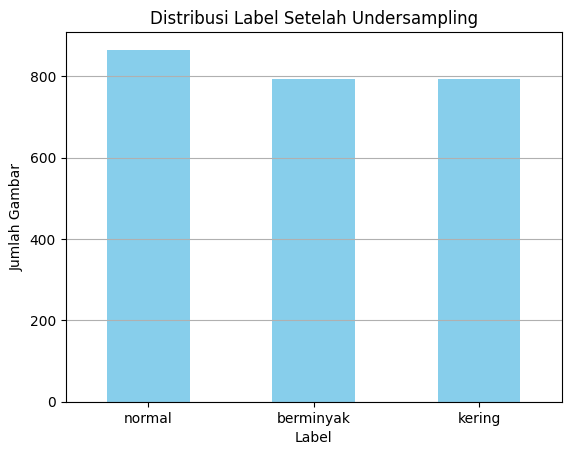

In [22]:
# Train
label_counts_undersampled_train = undersampled_train_df['label'].value_counts()
label_counts_undersampled_train.plot(kind='bar', color='skyblue')
plt.title("Distribusi Label Setelah Undersampling")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.grid(axis='y')

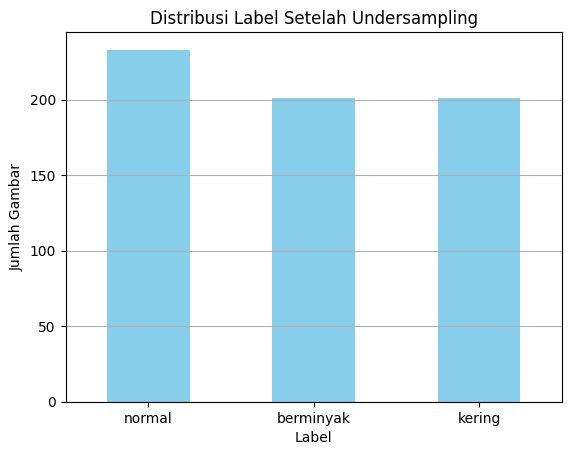

In [23]:
# Validation
label_counts_undersampled_train = undersampled_val_df['label'].value_counts()
label_counts_undersampled_train.plot(kind='bar', color='skyblue')
plt.title("Distribusi Label Setelah Undersampling")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.grid(axis='y')

#### Mengubah subfolder test menjadi dataframe

In [24]:
joined_test_dir='/content/skin_dataset/test/joined'

In [25]:
def joined_subfolder_to_dataframe(joined_test_dir):
    file_names = [f for f in os.listdir(joined_test_dir) if os.path.isfile(os.path.join(joined_test_dir, f))]

    data = []
    for fname in file_names:
        fpath = os.path.join(joined_test_dir, fname)
        label = extract_label_from_filename(fname)
        if label != 'unknown':
            data.append({'filepath': fpath, 'label': label})

    return pd.DataFrame(data)

In [26]:
test_df = joined_subfolder_to_dataframe(joined_test_dir)

In [27]:
test_df.head()

,filepath,label
0,/content/skin_dataset/test/joined/berminyak-13...,berminyak
1,/content/skin_dataset/test/joined/kering-44-_j...,kering
2,/content/skin_dataset/test/joined/normal-38-_j...,normal
3,/content/skin_dataset/test/joined/kering-86-_j...,kering
4,/content/skin_dataset/test/joined/kering-120-_...,kering


In [28]:
test_df['label'].value_counts()

,count
label,
berminyak,50
normal,26
kering,24


#### Augmentasi

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [30]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=undersampled_train_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=undersampled_val_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical',
    shuffle=False
)

Found 2449 validated image filenames belonging to 3 classes.
Found 635 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


## Modelling

In [ ]:
class accuracyOnTarget(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_accuracy') > 0.95 and logs.get('accuracy') > 0.95):
      print('\nVal Akurasi dan Accuracy telah mencapai 95%! Training selesai')
      self.model.stop_training = True
accuracyCallback = accuracyOnTarget()

In [ ]:
EarlyStopCallback = EarlyStopping(monitor='val_accuracy',patience=5)

In [ ]:
checkpoint = ModelCheckpoint("best_model_denseNet.keras", save_best_only=True)

In [ ]:
# labels = skin_image_df['labels'].values
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# class_weight_dict_rounded = {k: round(v, 1) for k, v in class_weight_dict.items()}
# print(class_weight_dict_rounded)

### Transfer Learning: DenseNet121


In [ ]:
basemodel_DenseNet121 =DenseNet121(
  include_top = False,
  weights='imagenet',
  input_tensor = tf.keras.layers.Input((300, 300, 3)),
)
basemodel_DenseNet121.trainable = False


model_1 = Sequential([
    basemodel_DenseNet121,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])
model_1.compile(optimizer=Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 9, 9, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │    84,935,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,662,595 (353.48 MB)

 Trainable params: 85,625,091 (326.63 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=[accuracyCallback, EarlyStopCallback,checkpoint],
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 786ms/step - accuracy: 0.4210 - loss: 173.5264 - val_accuracy: 0.7276 - val_loss: 0.7330
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.6360 - loss: 1.4264 - val_accuracy: 0.7984 - val_loss: 0.5089
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.7329 - loss: 0.6573 - val_accuracy: 0.7402 - val_loss: 0.6228
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.7894 - loss: 0.5675 - val_accuracy: 0.8850 - val_loss: 0.3641
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.8399 - loss: 0.4846 - val_accuracy: 0.8882 - val_loss: 0.3095
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.9129 - loss: 0.2847 - val_accuracy: 0.9102 - val_loss: 0.2883
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9351 - loss: 0.2110 - val_accuracy: 0.8772 - val_loss: 0.6388
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.8893 - loss: 0.3936 - val_accura

In [ ]:
model_1.save('/content/drive/MyDrive/capstone-project/best_model_DenseNet121.keras')

## Evaluasi dan Visualisasi

In [ ]:
def get_metrics(model, generator, steps, label_set):
    y_true = generator.classes
    y_pred_probs = model.predict(generator, steps=steps, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    precision = precision_score(y_true, y_pred, average='macro', labels=label_set)
    recall = recall_score(y_true, y_pred, average='macro', labels=label_set)
    f1 = f1_score(y_true, y_pred, average='macro', labels=label_set)

    return precision,recall,f1

In [ ]:
def evaluate_model(model, history, name, train_gen, test_gen):
    train_steps = train_gen.n // train_gen.batch_size + 1
    test_steps = test_gen.n // test_gen.batch_size + 1

    num_classes = len(train_gen.class_indices)
    label_set = list(range(num_classes))

    train_prec, train_rec, train_f1 = get_metrics(model, train_gen, train_steps, label_set)
    test_prec, test_rec, test_f1 = get_metrics(model, test_gen, test_steps, label_set)

    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    test_loss, test_acc = model_1.evaluate(test_gen, verbose=0)

    return {
        'Model': name,
        'Train Loss': round(train_loss, 4),
        'Train Accuracy (%)': round(train_acc * 100, 2),
        'Train Precision (%)': round(train_prec * 100, 2),
        'Train Recall (%)': round(train_rec * 100, 2),
        'Train F1-Score (%)': round(train_f1 * 100, 2),
        'Test Loss': round(test_loss, 4),
        'Test Accuracy (%)': round(test_acc * 100, 2),
        'Test Precision (%)': round(test_prec * 100, 2),
        'Test Recall (%)': round(test_rec * 100, 2),
        'Test F1-Score (%)': round(test_f1 * 100, 2),
    }


In [ ]:
evaluation_df = pd.DataFrame([
    evaluate_model(model_1, history_1, "DenseNet121", train_generator, test_generator)
])

display(evaluation_df)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


,Model,Train Loss,Train Accuracy (%),Train Precision (%),Train Recall (%),Train F1-Score (%),Test Loss,Test Accuracy (%),Test Precision (%),Test Recall (%),Test F1-Score (%)
0,DenseNet121,0.1995,94.0,33.62,33.62,33.62,0.7752,82.0,80.54,81.93,81.05


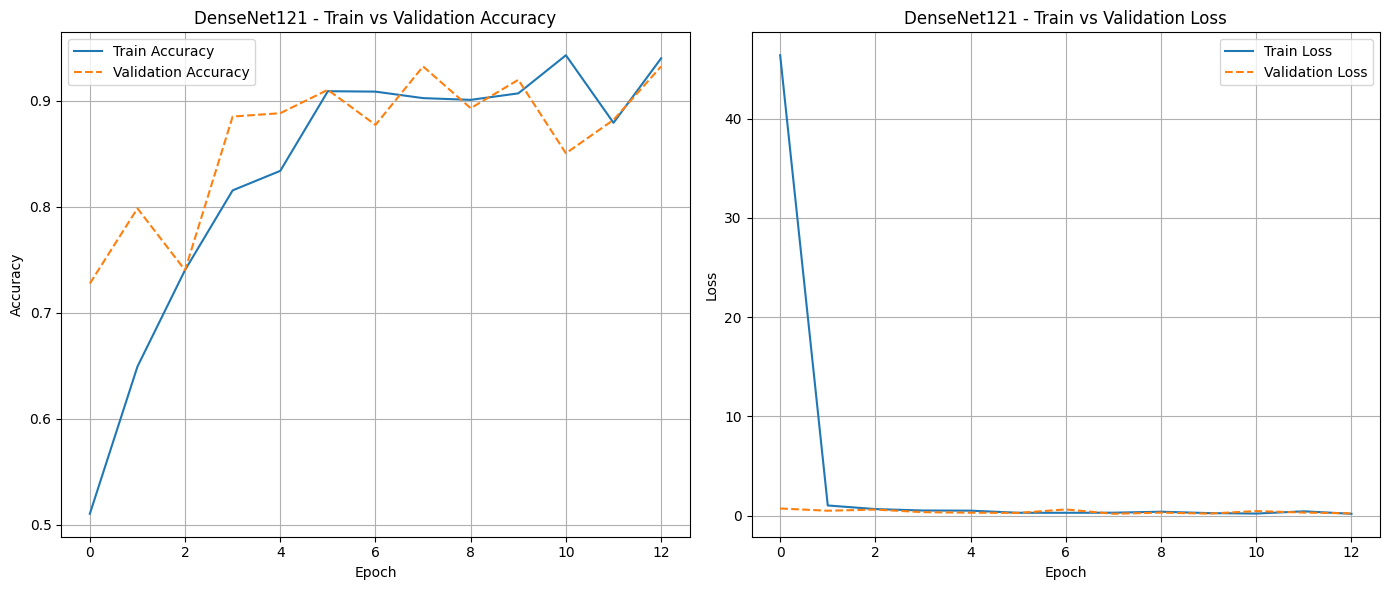

In [ ]:
plt.figure(figsize=(14, 6))
model_name = "DenseNet121"

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy', linestyle='-')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title(f'{model_name} - Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss', linestyle='-')
plt.plot(history_1.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title(f'{model_name} - Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()


In [ ]:
Y_pred = model_1.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_labels,
    digits=4
)
print("=== Classification Report ===")
print(report)

=== Classification Report ===
              precision    recall  f1-score   support

   berminyak     0.8913    0.8200    0.8542        50
      kering     0.7917    0.7917    0.7917        24
      normal     0.7333    0.8462    0.7857        26

    accuracy                         0.8200       100
   macro avg     0.8054    0.8193    0.8105       100
weighted avg     0.8263    0.8200    0.8214       100



## Inference

In [31]:
def preprocess_image(img_path, target_size=(300, 300)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [35]:
img_path = '/content/dry_skin2.jpg'
processed_img = preprocess_image(img_path)
best_model=load_model('/content/drive/MyDrive/capstone-project/Undersampled LR 0.01/best_model_DenseNet121.keras')

# Inference
pred_probs = best_model.predict(processed_img)
pred_class = np.argmax(pred_probs, axis=1)[0]

class_indices = test_generator.class_indices
labels_map = {v: k for k, v in class_indices.items()}
pred_label = labels_map[pred_class]

print(f"Prediksi: {pred_label} (Confidence: {np.max(pred_probs) * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediksi: kering (Confidence: 100.00%)
